# <font color='GoldenRod'>__Bayesian Optimisation Code: Configuration A1__</font>
---

// <font size='2' color = 'CornFlowerBlue'> __CFD Simulation Case__: </font><font size='2'> Momentum-Source Turbine Simulations 1/24 Periodic Boundary Conditions</font>

// <font size='2' color = 'IndianRed'> __BO Algorithm Type__: </font><font size='2'> Standardised Data + non ARD Kernel + Matern Kernel(3/2) + logEI Acquisition Function + Boundary Constraints + Overlapping Constraints </font>

// <font size='2' color = 'YellowGreen'> __Date and Location__: </font><font size='2'> March 17, 2025 - Google Drive - Version 1.0.0</font>

---

## <font size='3' color = 'CornFlowerBlue'> __Section A__: </font><font size='2'> ETL and Data Preprocessing of the Initial Seed for the Sequential Bayesian Optimisation Problem.</font>
---

In [161]:
# Part 1.1 Importing requiered libraries.
!pip install botorch
!pip install gpytorch
import sys                                          # Access to system files.
import warnings                                     # Warnings managment.
import numpy as np                                  # Numerical managment.
import pandas as pd                                 # DataFrames managment.
import matplotlib.pyplot as plt                     # Plots and graphs managment.
from sklearn.preprocessing import StandardScaler    # Data standardisation.
import torch                                        # Tensor-objects managment.
import botorch                                      # Bayesian Optimisation library.
import gpytorch                                     # Gaussian Process library.
from tqdm import tqdm                               # Progress bar for iterative processes.

In [162]:
# Part 1.2 Verifying and importing the datafiles.
[configuration, samples_in_data] = ["Configuration_A1", 99]
PATH = f"/content/{configuration}_{samples_in_data}_Sample_Simulations.csv"     # Relative path to the simulation results data.
data = pd.read_csv(filepath_or_buffer=PATH, header=0)                           # Importing the simulation results data.
data.drop(data.columns[[10, 11, 12]], axis=1, inplace=True)                     # Dropping non-requiered data columns.

# Part 1.2.1 Additional index confirmation of available samples and next candidate.
configuration_response = input(f"The configuration algorithms is for {configuration}. It is correct (y/n)?")    # Check for the configuration of the algorithm.
samples_response = input(f"The data contains {data.shape[0]} samples. It is correct (y/n)?")                    # Check for the number of samples availabe in data.
next_candidate_response = input(f"The next candidate index is {data.shape[0] + 1}. It is correct (y/n)?")       # Check for the index of the next best candidate.
if configuration_response == "y" and samples_response == "y" and next_candidate_response == "y":
    pass                                                                                                            # Continue with code execution.
else:                                                                                                               # If confirmation is incorrect.
    warnings.warn("Warning: Please check that algorithm, samples or index for sequential sampling is correct.")     # Warning for incorrect sequential sampling
    sys.exit()                                                                                                      # Terminate execution.

The configuration algorithms is for Configuration_A1. It is correct (y/n)?y
The data contains 99 samples. It is correct (y/n)?y
The next candidate index is 100. It is correct (y/n)?y


In [163]:
# Part 1.3 Standardising the data by using the StandardScale() skleanr function.
columns_to_standardise = data.columns[1:]                                               # First column Design_Point as index will not be standardised.
standardiser = StandardScaler()                                                         # Instanciating the StandardScaler() object.
standardiser_data = standardiser.fit_transform(data[columns_to_standardise])            # Applying the standardisation to data columns.

# Part 1.3.1 Transforming the standardised dato to a DataFrame and concatenate to the data imported.
standardiser_df = pd.DataFrame(standardiser_data, columns=[f'{col}_standardised' for col in columns_to_standardise])
data = pd.concat([data, standardiser_df], axis=1)
complete_data = data.describe()

# Part 1.3.2 Confirmation of the number of columns generated in data (index(1) + data(11) data_standardise(11) = 23).
if data.shape[1] == 23:
    print(f"Data shape is valid ({data.shape[1]} columns). Proceeding with the analysis.")
else:
    raise ValueError(f"Error: Expected 23 columns, but found {data.shape[1]} columns in the data.")

# Part 1.3.3 Saving the basic satatis data from data and standardised data.
complete_data.to_csv(f"Data_Parameters_Statistics_{data.shape[0]}_Simulations.csv")

Data shape is valid (23 columns). Proceeding with the analysis.


In [164]:
# Part 1.4 Computing the mean and standard deviation for variables associated to the original space.

# Computing the mean and std of the the radius_1, x_1 and y_1 of the first ring.
[radius_1_mean, radius_1_std] = [data["radius_1"].mean(), data["radius_1"].std(ddof=0)]
[x_1_mean, x_1_std] = [data["x_1"].mean(), data["x_1"].std(ddof=0)]
[y_1_mean, y_1_std] = [data["y_1"].mean(), data["y_1"].std(ddof=0)]

# Computing the mean and std of the the radius_2, x_2 and y_2 of the second ring.
[radius_2_mean, radius_2_std] = [data["radius_2"].mean(), data["radius_2"].std(ddof=0)]
[x_2_mean, x_2_std] = [data["x_2"].mean(), data["x_2"].std(ddof=0)]
[y_2_mean, y_2_std] = [data["y_2"].mean(), data["y_2"].std(ddof=0)]

# Computing the mean and std of the the radius_3, x_3 and y_3 of the third ring.
[radius_3_mean, radius_3_std] = [data["radius_3"].mean(), data["radius_3"].std(ddof=0)]
[x_3_mean, x_3_std] = [data["x_3"].mean(), data["x_3"].std(ddof=0)]
[y_3_mean, y_3_std] = [data["y_3"].mean(), data["y_3"].std(ddof=0)]

In [165]:
# Part 1.5 Defining the original and standarised bounds.

# Part 1.5.1 Bounds in the original space.
# Bounds for the first ring
[radius_1_min_bound, radius_1_max_bound] = [0.01, 0.025]                # Minimum and maximum radius in meters
[x_1_min_bound, x_1_max_bound] = [-0.125 + 0.275, 0.125 + 0.275]        # Minimum and maximum x-coordinates in meters
[y_1_min_bound, y_1_max_bound] = [0.0 + 0.590, 0.1 + 0.590]             # Minimum and maximum y-coordinates in meters

# Bounds for the second ring.
[radius_2_min_bound, radius_2_max_bound] = [0.01, 0.025]                # Minimum and maximum radius in meters
[x_2_min_bound, x_2_max_bound] = [-0.125 + 0.275, 0.125 + 0.275]        # Minimum and maximum x-coordinates in meters
[y_2_min_bound, y_2_max_bound] = [0.0 + 0.590, 0.1 + 0.590]             # Minimum and maximum y-coordinates in meters

# Bounds for the third ring.
[radius_3_min_bound, radius_3_max_bound] = [0.01, 0.025]                # Minimum and maximum radius in meters
[x_3_min_bound, x_3_max_bound] = [-0.125 + 0.275, 0.125 + 0.275]        # Minimum and maximum x-coordinates in meters
[y_3_min_bound, y_3_max_bound] = [0.0 + 0.590, 0.1 + 0.590]             # Minimum and maximum y-coordinates in meters

# Part 1.5.2 Bounds in the standardised space.
# Bounds for the first ring.
[radius_1_min_standardised_bound, radius_1_max_standardised_bound] = [(radius_1_min_bound - radius_1_mean) / radius_1_std, (radius_1_max_bound - radius_1_mean) / radius_1_std]
[x_1_min_standardised_bound, x_1_max_standardised_bound] = [(x_1_min_bound - x_1_mean) / x_1_std, (x_1_max_bound - x_1_mean) / x_1_std]
[y_1_min_standardised_bound, y_1_max_standardised_bound] = [(y_1_min_bound - y_1_mean) / y_1_std, (y_1_max_bound - y_1_mean) / y_1_std]

# Bounds for the second ring.
[radius_2_min_standardised_bound, radius_2_max_standardised_bound] = [(radius_2_min_bound - radius_2_mean) / radius_2_std, (radius_2_max_bound - radius_2_mean) / radius_2_std]
[x_2_min_standardised_bound, x_2_max_standardised_bound] = [(x_2_min_bound - x_2_mean) / x_2_std, (x_2_max_bound - x_2_mean) / x_2_std]
[y_2_min_standardised_bound, y_2_max_standardised_bound] = [(y_2_min_bound - y_2_mean) / y_2_std, (y_2_max_bound - y_2_mean) / y_2_std]

# Bounds for the third ring.
[radius_3_min_standardised_bound, radius_3_max_standardised_bound] = [(radius_3_min_bound - radius_3_mean) / radius_3_std, (radius_3_max_bound - radius_3_mean) / radius_3_std]
[x_3_min_standardised_bound, x_3_max_standardised_bound] = [(x_3_min_bound - x_3_mean) / x_3_std, (x_3_max_bound - x_3_mean) / x_3_std]
[y_3_min_standardised_bound, y_3_max_standardised_bound] = [(y_3_min_bound - y_3_mean) / y_3_std, (y_3_max_bound - y_3_mean) / y_3_std]

## <font size='3' color = 'CornFlowerBlue'> __Section B__: </font><font size='2'> Defining the Gaussian Process Model Configuration and Bayesian Optimisation Loop.</font>

In [166]:
# Part 2.1 Defining the training data for the Gaussian Process regression.

# Extracting the data from the Pandas DataFrame.
train_x = data[["radius_1_standardised", "x_1_standardised", "y_1_standardised",
                "radius_2_standardised", "x_2_standardised", "y_2_standardised",
                "radius_3_standardised", "x_3_standardised", "y_3_standardised"]]
train_y = data[["Ideal_Turbine_Power_standardised"]]

# Converting the train data into a Numpy Ndarray object (do not use detach to preserve gradients).
train_x_np = train_x.to_numpy()
train_y_np = train_y.to_numpy()

# Converting the train data into a Torch tensor object (train_y_tensor variable must be squeezed).
train_x_tensor = torch.tensor(train_x_np, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_np, dtype=torch.float32).squeeze()

In [167]:
# Part 2.2 Defining the Gaussian Process regression model object (Torch object).
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):                  # Exact GP assuming numerical stability (otherwise ApproximateGP)
    _num_outputs = 1                                                                            # Single output GP regressor (Multi-output for objective-variable constraints).
    def __init__(self, train_x, train_y, likelihood):                                               # Calling the parent class constructor.
        super().__init__(train_x, train_y, likelihood)                                              # Calling the super() class access constructor.
        self.mean_module = gpytorch.means.ConstantMean()                                            # Constant mean assuming GP is a stationary process.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))     # Scale kernel decorator - Matern kernel assuming GP is not a smooth process.
    def forward(self, x):                                                                           # Defining the forward pass.
        mean_x = self.mean_module(x)                                                                # Applying the mean module.
        covar_x = self.covar_module(x)                                                              # Applying the covariance module.
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)                           # Returning the multivariate normal distribution.

In [168]:
# Part 2.3 Initialising and training the Gaussian Proces regression model.
noise = 1e-4            # Assuming data is derived form free-noise samples.

# Part 2.3.1 Instanciating the likelihood and Gaussian Process regression model.
likelihood = gpytorch.likelihoods.GaussianLikelihood()          # Grafient information requiered (no binary or categorical data).
model = GPModel(train_x_tensor, train_y_tensor, likelihood)     # Instanciating the GP model.
model.likelihood.noise = noise                                  # Definition of the noise in the GP model.

# Part 2.3.2 Training the hyperaparameters of the GP model by minimisating the negative likelihood.
optimiser = torch.optim.Adam(model.parameters(), lr=0.0025)             # Adaptative momentum gradient-base optimiser (alternative: Nesterov-Adam)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)       # Marginal log-likelihood GP model definition.

model.train()                                                           # Enabling the training mode of the model
likelihood.train()                                                      # Enabling the training mode of the likelihood.

# Part 2.3.3 Defing the optimisation loop to determine the GP model hyperparameters.
[losses, mean_constant, lengthscale] = [[], [], []]                     # History lists of hyperparameters.
for i in tqdm(range(5000)):
    optimiser.zero_grad()                                               # Prevent unintended accumulation in gradient calculation.
    output = model(train_x_tensor)
    loss = -mll(output, train_y_tensor)
    loss.backward()
    losses.append(loss.item())
    mean_constant.append(model.mean_module.constant.item())
    lengthscale.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    output_scales = model.covar_module.outputscale.item()
    optimiser.step()

model.eval()                                                            # Enabling evaluation mode of the model.
likelihood.eval()                                                       # Enabling evaluation mode of the likelihood.

100%|██████████| 5000/5000 [00:44<00:00, 112.72it/s]


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

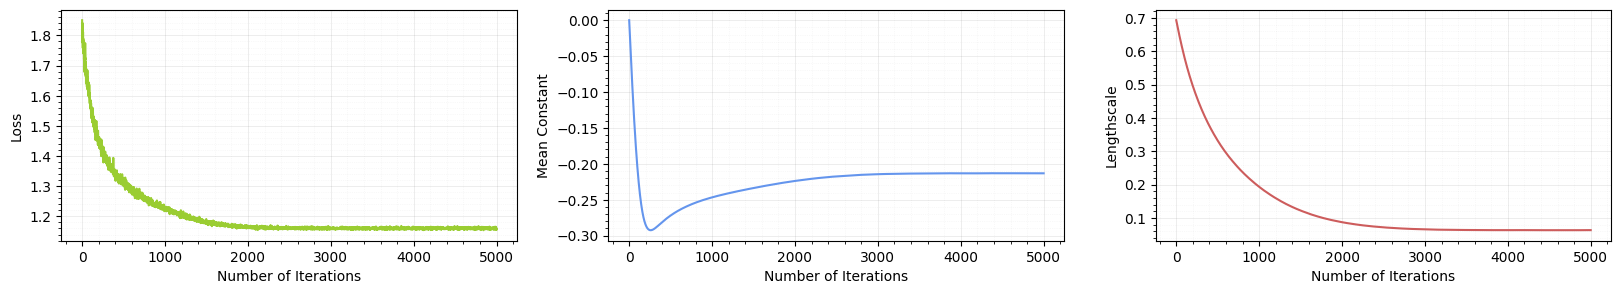

In [169]:
# Part 2.4 Plotting the Gaussian Process optimisation loop results.

# Plotting the hyperparameters of the Gaussian Process model.
fig, ax = plt.subplots(1, 3, figsize=(20, 3))

ax[0].plot(losses, color="YellowGreen")
ax[0].set_xlabel("Number of Iterations")
ax[0].set_ylabel("Loss")
ax[0].minorticks_on()
ax[0].grid(which='major', linestyle='-', linewidth='0.5', color='grey', alpha=0.2)
ax[0].grid(which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.1)

ax[1].plot(mean_constant, color="CornFlowerBlue")
ax[1].set_xlabel("Number of Iterations")
ax[1].set_ylabel("Mean Constant")
ax[1].minorticks_on()
ax[1].grid(which='major', linestyle='-', linewidth='0.5', color='grey', alpha=0.2)
ax[1].grid(which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.1)

ax[2].plot(lengthscale, color="IndianRed")
ax[2].set_xlabel("Number of Iterations")
ax[2].set_ylabel("Lengthscale")
ax[2].minorticks_on()
ax[2].grid(which='major', linestyle='-', linewidth='0.5', color='grey', alpha=0.2)
ax[2].grid(which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.1)

plt.savefig(f"Hyperparameters_Tuning_GP_Plot_{data.shape[0]}_Simulations.png", dpi=300)

In [170]:
# Part 2.5 Saving the hyperparameter tunin values. Hyperaparameter Tuning Values (HTV)
htv_data = pd.DataFrame({'Design_Point': [data.shape[0] + 1],
                         'Losses': [losses[-1]],
                         'Mean_Constant': [mean_constant[-1]],
                         'Lengthscale': [lengthscale[-1]]})

# Save the new DataFrame to Google Drive
htv_data.to_csv(f"Hyperparameter_Tuning_GP_Values_{data.shape[0]}_Simulations.csv", index=False)

## <font size='3' color = 'CornFlowerBlue'> __Section C__: </font><font size='2'> Defining the Bayesian Optimisation Loop and Functions for Bounds Constrictions.</font>

In [171]:
# Part 3.1 Generating a function to handle with overlapping constraint between any of three circles.
def overlap_constraint(X_standardised):
    """
    Calculates the overlap between circles represented by X_standardised (in standardized space).
    In code, a 1mm (0.001m) to each circle's radius when checking for overlap as a safety buffer.
    """
    circles_standardised = X_standardised.reshape(-1, 3, 3)

    radius_means = torch.tensor([radius_1_mean, radius_2_mean, radius_3_mean])
    radius_stds = torch.tensor([radius_1_std, radius_2_std, radius_3_std])
    x_means = torch.tensor([x_1_mean, x_2_mean, x_3_mean])
    x_stds = torch.tensor([x_1_std, x_2_std, x_3_std])
    y_means = torch.tensor([y_1_mean, y_2_mean, y_3_mean])
    y_stds = torch.tensor([y_1_std, y_2_std, y_3_std])

    # Safety buffer in meters
    safety_buffer = 0.001  # 1 mm

    def calculate_overlap(circle1_idx, circle2_idx):
        """
        (Auxiliar function). Calculates the overlap between two circles represented by X_standardised (in standardised space).
        """
        # Calculate centers from the standardised space to the original space
        centers_1 = circles_standardised[:, circle1_idx, 1:] * torch.tensor([x_stds[circle1_idx], y_stds[circle1_idx]]) + torch.tensor([x_means[circle1_idx], y_means[circle1_idx]])
        centers_2 = circles_standardised[:, circle2_idx, 1:] * torch.tensor([x_stds[circle2_idx], y_stds[circle2_idx]]) + torch.tensor([x_means[circle2_idx], y_means[circle2_idx]])

        # Calculate distance between centers
        distances_original = torch.norm(centers_1 - centers_2, dim=-1)

        # Calculate the individual radii with safety buffer
        radius_1 = circles_standardised[:, circle1_idx, 0] * radius_stds[circle1_idx] + radius_means[circle1_idx] + safety_buffer
        radius_2 = circles_standardised[:, circle2_idx, 0] * radius_stds[circle2_idx] + radius_means[circle2_idx] + safety_buffer

        # Calculate sum of pairwise circle radii (including the safety buffer)
        radii_sums_original = radius_1 + radius_2
        return radii_sums_original - distances_original

    # Computing the distance for each par of circles.
    overlap_12 = calculate_overlap(0, 1)
    overlap_13 = calculate_overlap(0, 2)
    overlap_23 = calculate_overlap(1, 2)

    # Retrieving the maximum distance for overlapping between circles.
    all_overlaps = torch.stack([overlap_12, overlap_13, overlap_23], dim=1)
    return -torch.max(all_overlaps, dim=1)[0].squeeze()

In [172]:
# Part 3.2 Generation a function to handle out of bounds constriction between any of three circles.
def boundary_constraint(X_standardized):
    """
    Calculates how much circles extend beyond the boundaries (in original space).
    Returns a non-negative value when all circles are entirely within boundaries,
    and a negative value when any circle extends beyond the boundaries.
    """
    # Reshape input to get parameters for each circle
    circles_standardized = X_standardized.reshape(-1, 3, 3)

    # Define means and standard deviations for unstandardizing
    radius_means = torch.tensor([radius_1_mean, radius_2_mean, radius_3_mean])
    radius_stds = torch.tensor([radius_1_std, radius_2_std, radius_3_std])
    x_means = torch.tensor([x_1_mean, x_2_mean, x_3_mean])
    x_stds = torch.tensor([x_1_std, x_2_std, x_3_std])
    y_means = torch.tensor([y_1_mean, y_2_mean, y_3_mean])
    y_stds = torch.tensor([y_1_std, y_2_std, y_3_std])

    # Define boundaries in original space
    x_min = torch.tensor([-0.125 + 0.275, -0.125 + 0.275, -0.125 + 0.275])  # Min x for each circle
    x_max = torch.tensor([0.125 + 0.275, 0.125 + 0.275, 0.125 + 0.275])     # Max x for each circle
    y_min = torch.tensor([0.0 + 0.590, 0.0 + 0.590, 0.0 + 0.590])           # Min y for each circle
    y_max = torch.tensor([0.1 + 0.590, 0.1 + 0.590, 0.1 + 0.590])           # Max y for each circle

    # Calculate violations for all circles
    violations = []

    for i in range(3):
        # Convert standardized values to original space
        radius = circles_standardized[:, i, 0] * radius_stds[i] + radius_means[i]
        x = circles_standardized[:, i, 1] * x_stds[i] + x_means[i]
        y = circles_standardized[:, i, 2] * y_stds[i] + y_means[i]

        # Calculate distance from circle edge to each boundary
        left_dist = (x - x_min[i]) - radius    # Distance from left edge of circle to left boundary
        right_dist = (x_max[i] - x) - radius   # Distance from right edge of circle to right boundary
        bottom_dist = (y - y_min[i]) - radius  # Distance from bottom edge of circle to bottom boundary
        top_dist = (y_max[i] - y) - radius     # Distance from top edge of circle to top boundary

        # Stack all distances
        all_dists = torch.stack([left_dist, right_dist, bottom_dist, top_dist], dim=1)

        # Find the minimum distance (most violated or least satisfied boundary)
        min_dist = torch.min(all_dists, dim=1)[0]
        violations.append(min_dist)

    # Stack all violations and find the most violated constraint across all circles
    all_violations = torch.stack(violations, dim=1)
    worst_violation = torch.min(all_violations, dim=1)[0]
    return worst_violation

In [173]:
# Part 3.3 Generating a function to
def generate_valid_initial_batch(num_samples=200, max_attempts=1000):
    """
    Generate a batch of valid initial points where circles don't overlap and stay within bounds.
    The function is code to satisfy the num samples by using a maximum number of attempts.
    Args:
        num_samples: Number of valid samples to generate
        max_attempts: Maximum number of attempts before giving up
    Returns:
        torch.Tensor of shape (num_valid_samples, 9) containing valid configurations
    """
    valid_samples = []              # List where valid samples will be stored.
    attempts = 0                    # Initialising the counter for attemps.

    # Define standardized bounds (TODO: bounds should be passed as an argument in the function)
    bounds = torch.tensor([[radius_1_min_standardised_bound, radius_1_max_standardised_bound],
                           [x_1_min_standardised_bound, x_1_max_standardised_bound],
                           [y_1_min_standardised_bound, y_1_max_standardised_bound],
                           [radius_2_min_standardised_bound, radius_2_max_standardised_bound],
                           [x_2_min_standardised_bound, x_2_max_standardised_bound],
                           [y_2_min_standardised_bound, y_2_max_standardised_bound],
                           [radius_3_min_standardised_bound, radius_3_max_standardised_bound],
                           [x_3_min_standardised_bound, x_3_max_standardised_bound],
                           [y_3_min_standardised_bound, y_3_max_standardised_bound],])

    while len(valid_samples) < num_samples and attempts < max_attempts:
        # Generate a batch of candidate points
        batch_size = min(500, num_samples * 10)  # Generate multiple candidates at once for efficiency
        batch = torch.rand(batch_size, 9)
        # Scale the random samples to the defined bounds
        for i in range(9):
            batch[:, i] = batch[:, i] * (bounds[i, 1] - bounds[i, 0]) + bounds[i, 0]
        overlap_values = overlap_constraint(batch)                          # Check for overlapp constraint.
        boundary_values = boundary_constraint(batch)                        # Check for boundary constraint.
        valid_indices = (overlap_values >= 0) & (boundary_values >= 0)      # Find samples that satisfy both constraints
        valid_batch = batch[valid_indices]                                  # Extract valid samples indices.
        valid_samples.append(valid_batch)                                   # Add valid samples to the list collection.

        # Update attempts
        attempts += 1

        # Print progress
        if len(valid_samples) > 0:
            total_valid = sum(s.shape[0] for s in valid_samples)

    # Combine all valid samples
    if len(valid_samples) > 0:
        all_valid_samples = torch.cat(valid_samples, dim=0)

        # If we have more than needed, take the first num_samples
        if all_valid_samples.shape[0] > num_samples:
            all_valid_samples = all_valid_samples[:num_samples]

        print(f"Final valid sample count: {all_valid_samples.shape[0]}")
        return all_valid_samples
    else:
        print("Could not find any valid samples. Try increasing max_attempts or adjusting constraints.")
        return torch.zeros(0, 9)  # Return empty tensor

In [174]:
# Part 3.4 Generate the initial sample batch for Bayesian Optimisation.
train_x_initial = generate_valid_initial_batch(num_samples=2000, max_attempts=1000)

# Additional check
if train_x_initial.shape[0] > 0:
    print(f"Successfully generated {train_x_initial.shape[0]} valid initial points")
else:
    print("Failed to generate valid initial points. Consider relaxing constraints or bounds.")

Final valid sample count: 2000
Successfully generated 2000 valid initial points


In [175]:
# Part 3.5 Definig the main Bayesian Optimisation Loop.
bounds = torch.tensor([[radius_1_min_standardised_bound, x_1_min_standardised_bound, y_1_min_standardised_bound,
                        radius_2_min_standardised_bound, x_2_min_standardised_bound, y_2_min_standardised_bound,
                        radius_3_min_standardised_bound, x_3_min_standardised_bound, y_3_min_standardised_bound],
                        [radius_1_max_standardised_bound, x_1_max_standardised_bound, y_1_max_standardised_bound,
                         radius_2_max_standardised_bound, x_2_max_standardised_bound, y_2_max_standardised_bound,
                         radius_3_max_standardised_bound, x_3_max_standardised_bound, y_3_max_standardised_bound]], dtype=torch.float32)

# Defining the number of queries (by default=1 for Sequential Single-Output Bayesian Optimisation).
num_queries = 1

# Defining the policy for best_candidate selection by defaul=logExpectedImprovement (alternatives: EI, PoI, UCB).
# policy = botorch.acquisition.UpperConfidenceBound(model=model, beta=0.99, maximize=True)
policy = botorch.acquisition.LogExpectedImprovement(model=model, best_f=train_y_tensor.max(), maximize=True)


# Defining the next best candidate and the acquisition value associated.
next_x, acq_value = botorch.optim.optimize_acqf(policy,
                                                bounds=bounds,
                                                q=num_queries,
                                                num_restarts=100,
                                                nonlinear_inequality_constraints=[(overlap_constraint, False), (boundary_constraint, False)],
                                                batch_initial_conditions=train_x_initial.reshape(-1, 1, 9).contiguous())
print(f"Next best candidate: {next_x}")
print(f"Acquisition value: {acq_value}")

Next best candidate: tensor([[ 0.9841, -1.2420,  0.4724, -0.9192,  0.4634,  1.9804, -0.8023,  0.3778,
         -0.7195]])
Acquisition value: -8.154706954956055


In [176]:
# Part 3.6 Making predictions of the next sampling point in the standarised space

with torch.no_grad():
    posterior = model(next_x)                                               # Get the posterior distribution
    mean_prediction = posterior.mean                                        # Extract the mean
    variance_prediction = posterior.variance                                # Extract the variance
    std_prediction = variance_prediction.sqrt()                             # Calculate the standard deviation
    upper_confidence_bound = mean_prediction + 1.96 * std_prediction        # 95% confidence
    lower_confidence_bound = mean_prediction - 1.96 * std_prediction        # 95% confidence

print("Predicted Mean (Standardised Space):", mean_prediction.item())
print("Upper Confidence Bound (Standardised Space):", upper_confidence_bound.item())
print("Lower Confidence Bound (Standardised Space):", lower_confidence_bound.item())

Predicted Mean (Standardised Space): -0.21315144002437592
Upper Confidence Bound (Standardised Space): 1.4318208694458008
Lower Confidence Bound (Standardised Space): -1.858123779296875


In [177]:
# Part 3.7 Making predictions of the next sampling point in the original space.

mean_prediction_original = mean_prediction.item() * data["Ideal_Turbine_Power"].std(ddof=0) + data["Ideal_Turbine_Power"].mean()
std_prediction_original = std_prediction.item() * data["Ideal_Turbine_Power"].std(ddof=0)
upper_confidence_bound_original = upper_confidence_bound.item() * data["Ideal_Turbine_Power"].std(ddof=0) + data["Ideal_Turbine_Power"].mean()
lower_confidence_bound_original = lower_confidence_bound.item() * data["Ideal_Turbine_Power"].std(ddof=0) + data["Ideal_Turbine_Power"].mean()

print("Predicted Mean (Original Space):", mean_prediction_original)
print("Standard Deviation (Original Space):", std_prediction_original)
print("Upper Confidence Bound (Original Space):", upper_confidence_bound_original)
print("Lower Confidence Bound (Original Space):", lower_confidence_bound_original)


Predicted Mean (Original Space): 892.8431269760135
Standard Deviation (Original Space): 53.71123126163675
Upper Confidence Bound (Original Space): 998.1171379219494
Lower Confidence Bound (Original Space): 787.5691141228053


In [178]:
# Part 3.8 Transforming the next sampling point from standarised space to original space.

next_x_original = next_x.clone()

# Transforming the radius, x and y coordinates of the first ring.
next_x_original[:, 0] = (next_x[:, 0] * radius_1_std) + radius_1_mean
next_x_original[:, 1] = (next_x[:, 1] * x_1_std) + x_1_mean
next_x_original[:, 2] = (next_x[:, 2] * y_1_std) + y_1_mean

# Transforming the radius, x and y coordinates of the second ring.
next_x_original[:, 3] = (next_x[:, 3] * radius_2_std) + radius_2_mean
next_x_original[:, 4] = (next_x[:, 4] * x_2_std) + x_2_mean
next_x_original[:, 5] = (next_x[:, 5] * y_2_std) + y_2_mean

# Transforming the radius, x and y coordinates of the third ring.
next_x_original[:, 6] = (next_x[:, 6] * radius_3_std) + radius_3_mean
next_x_original[:, 7] = (next_x[:, 7] * x_3_std) + x_3_mean
next_x_original[:, 8] = (next_x[:, 8] * y_3_std) + y_3_mean

print("Next X (Original Space):", next_x_original)


Next X (Original Space): tensor([[0.0221, 0.2023, 0.6536, 0.0139, 0.2937, 0.6755, 0.0138, 0.3108, 0.6210]])


In [179]:
# Part 3.9 Saving the prediction data made in the originial space NextCandidate Original Space (NOS)
nos_data = pd.DataFrame(columns=['Design_Point', 'radius_1', 'x_1', 'y_1',
                                 'radius_2', 'x_2', 'y_2',
                                 'radius_3', 'x_3', 'y_3',
                                 'F_objective_Mean', 'F_objective_UCB',
                                 'F_objective_LCB', 'F_objective_Std', 'Acq_value'])
nos_data.loc[data.shape[0]] = [data.shape[0] + 1, next_x_original[0, 0].item(), next_x_original[0, 1].item(), next_x_original[0, 2].item(),
                              next_x_original[0, 3].item(), next_x_original[0, 4].item(), next_x_original[0, 5].item(),
                              next_x_original[0, 6].item(), next_x_original[0, 7].item(), next_x_original[0, 8].item(),
                              mean_prediction_original, upper_confidence_bound_original, lower_confidence_bound_original, std_prediction_original, acq_value]
nos_data.to_csv(f"Next_Sampling_Point_{data.shape[0] + 1}_Simulations.csv", index=False)

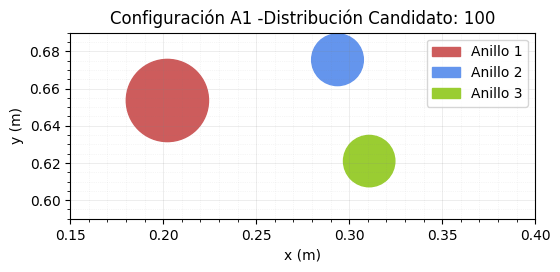

In [180]:
# 3.10 Plotting the results to visualise non-apparent restrictions errors.

# Extract circle parameters
radius_1 = next_x_original[0, 0].item()
x_1 = next_x_original[0, 1].item()
y_1 = next_x_original[0, 2].item()

radius_2 = next_x_original[0, 3].item()
x_2 = next_x_original[0, 4].item()
y_2 = next_x_original[0, 5].item()

radius_3 = next_x_original[0, 6].item()
x_3 = next_x_original[0, 7].item()
y_3 = next_x_original[0, 8].item()

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the circles
circle1 = plt.Circle((x_1, y_1), radius_1, color='IndianRed', label='Anillo 1')
circle2 = plt.Circle((x_2, y_2), radius_2, color='CornFlowerBlue', label='Anillo 2')
circle3 = plt.Circle((x_3, y_3), radius_3, color='YellowGreen', label='Anillo 3')

ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

# Set plot limits
ax.set_xlim([-0.125 + 0.275, 0.125 + 0.275])
ax.set_ylim([0.0 + 0.590, 0.1 + 0.590])
ax.set_aspect('equal')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f"Configuración A1 -Distribución Candidato: {data.shape[0] + 1}")
plt.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', alpha=0.2)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey', alpha=0.15)
plt.legend()
plt.savefig(f"Next_Sampling_Point_{data.shape[0] + 1}_Simulations.png", dpi=300)

In [181]:
# Part 3.11 Generating the following sample CSV file.
next_file = pd.read_csv(filepath_or_buffer=PATH, header=0)
next_file = pd.concat([next_file, pd.DataFrame([next_x_original.numpy().flatten().tolist()], columns=['radius_1', 'x_1', 'y_1', 'radius_2', 'x_2', 'y_2', 'radius_3', 'x_3', 'y_3'])], ignore_index=True)
next_file.loc[next_file.shape[0]-1, 'Design_Point'] = data.shape[0] + 1
next_file.to_csv(f"/content/{configuration}_{samples_in_data + 1}_Sample_Simulations_Incomplete.csv", index=False)

In [182]:
# Part 3.12 Downloading generated files
from google.colab import files
import zipfile
import os

file_1 = f"/content/{configuration}_{samples_in_data + 1}_Sample_Simulations_Incomplete.csv"
file_2 = f"/content/Data_Parameters_Statistics_{data.shape[0]}_Simulations.csv"
file_3 = f"/content/Hyperparameter_Tuning_GP_Values_{data.shape[0]}_Simulations.csv"
file_4 = f"/content/Hyperparameters_Tuning_GP_Plot_{data.shape[0]}_Simulations.png"
file_5 = f"/content/Next_Sampling_Point_{data.shape[0] + 1}_Simulations.csv"
file_6 = f"/content/Next_Sampling_Point_{data.shape[0] + 1}_Simulations.png"

def compress_and_download(file_list, zip_filename):
  """Compresses a list of files into a zip archive and downloads it."""
  with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file_path in file_list:
      if os.path.exists(file_path):
        zipf.write(file_path, os.path.basename(file_path))
      else:
        print(f"Warning: File '{file_path}' not found.")
  files.download(zip_filename)


file_list = [file_1, file_2, file_3, file_4, file_5, file_6]
zip_filename = f"Compressed_Files_Simulation_Sample_{data.shape[0]}_to_Candidate_{data.shape[0] + 1}.zip"
compress_and_download(file_list, zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [183]:
# Deleting temporal files created.

file_1 = f"/content/{configuration}_{samples_in_data + 1}_Sample_Simulations_Incomplete.csv"
file_2 = f"/content/Data_Parameters_Statistics_{data.shape[0]}_Simulations.csv"
file_3 = f"/content/Hyperparameter_Tuning_GP_Values_{data.shape[0]}_Simulations.csv"
file_4 = f"/content/Hyperparameters_Tuning_GP_Plot_{data.shape[0]}_Simulations.png"
file_5 = f"/content/Next_Sampling_Point_{data.shape[0] + 1}_Simulations.csv"
file_6 = f"/content/Next_Sampling_Point_{data.shape[0] + 1}_Simulations.png"

files_to_delete = [file_1, file_2, file_3, file_4, file_5, file_6]

for file_path in files_to_delete:
  if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' deleted successfully.")
  else:
    print(f"File '{file_path}' not found.")


File '/content/Configuration_A1_100_Sample_Simulations_Incomplete.csv' deleted successfully.
File '/content/Data_Parameters_Statistics_99_Simulations.csv' deleted successfully.
File '/content/Hyperparameter_Tuning_GP_Values_99_Simulations.csv' deleted successfully.
File '/content/Hyperparameters_Tuning_GP_Plot_99_Simulations.png' deleted successfully.
File '/content/Next_Sampling_Point_100_Simulations.csv' deleted successfully.
File '/content/Next_Sampling_Point_100_Simulations.png' deleted successfully.
